In [1]:
!pip install torch_geometric

StatementMeta(team14elliptic, 25, 2, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.9 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when, isnull, sum as _sum, desc, udf
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import uuid
import os

StatementMeta(team14elliptic, 25, 5, Finished, Available, Finished)

In [5]:
# Azure Blob Storage configuration
storage_account_name = "team14storage"
storage_account_key = "BqTUGm0vEddQ0O5wOaAzGNjFqZVnK4ZnhfvBYjBhfLbcBPoeO43ABkRBPhdgzwuyzoYDInfw0wjs+ASt89HrGw=="
file_path = (
    f"wasbs://team14-blobcontainer@{storage_account_name}" 
    + ".blob.core.windows.net/Bronze/TransactionalData/DG_out.csv"
)
spark.conf.set(
    f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net", 
    storage_account_key
)

StatementMeta(team14elliptic, 25, 6, Finished, Available, Finished)

In [6]:
# Helper function to save dataframes to Gold container
def save_to_gold(df, name):
    """Save dataframe to Gold container with unique folder name to avoid conflicts"""
    unique_id = str(uuid.uuid4())[:8]  # Generate a short unique ID
    gold_path = f"wasbs://team14-blobcontainer@{storage_account_name}.blob.core.windows.net/Gold/{name}_{unique_id}"
    try:
        # Save the dataframe
        df.write.mode("overwrite").parquet(gold_path)
        print(f"Successfully saved {name} to {gold_path}")
        return gold_path
    except Exception as e:
        print(f"Error saving {name}: {str(e)}")
        # Try alternative approach for small dataframes
        try:
            # For smaller dataframes, try different format
            df.write.mode("overwrite").csv(gold_path + "_csv")
            print(f"Successfully saved {name} as CSV to {gold_path}_csv")
            return gold_path + "_csv"
        except Exception as e2:
            print(f"Error saving {name} as CSV: {str(e2)}")
            return None

StatementMeta(team14elliptic, 25, 7, Finished, Available, Finished)

In [7]:
# Read the CSV file
df = spark.read.csv(file_path, header=True, inferSchema=True)

StatementMeta(team14elliptic, 25, 8, Finished, Available, Finished)

In [8]:
# Display basic information
print("Schema:")
df.printSchema()
print("\nSample Data:")
df.show(5)
print("\nDataset Statistics:")
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

StatementMeta(team14elliptic, 25, 9, Finished, Available, Finished)

Schema:
root
 |-- tx_hash: string (nullable = true)
 |-- indegree: integer (nullable = true)
 |-- outdegree: integer (nullable = true)
 |-- in_btc: double (nullable = true)
 |-- out_btc: double (nullable = true)
 |-- total_btc: double (nullable = true)
 |-- mean_in_btc: double (nullable = true)
 |-- mean_out_btc: double (nullable = true)
 |-- in_malicious: integer (nullable = true)
 |-- out_malicious: integer (nullable = true)
 |-- is_malicious: integer (nullable = true)
 |-- out_and_tx_malicious: integer (nullable = true)
 |-- all_malicious: integer (nullable = true)


Sample Data:
+--------------------+--------+---------+------+-------+---------+-----------+------------+------------+-------------+------------+--------------------+-------------+
|             tx_hash|indegree|outdegree|in_btc|out_btc|total_btc|mean_in_btc|mean_out_btc|in_malicious|out_malicious|is_malicious|out_and_tx_malicious|all_malicious|
+--------------------+--------+---------+------+-------+---------+----------

In [9]:
# Count null values in each column
null_counts = df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
print("\nNull values count by column:")
null_counts.show()

StatementMeta(team14elliptic, 25, 10, Finished, Available, Finished)


Null values count by column:
+-------+--------+---------+------+-------+---------+-----------+------------+------------+-------------+------------+--------------------+-------------+
|tx_hash|indegree|outdegree|in_btc|out_btc|total_btc|mean_in_btc|mean_out_btc|in_malicious|out_malicious|is_malicious|out_and_tx_malicious|all_malicious|
+-------+--------+---------+------+-------+---------+-----------+------------+------------+-------------+------------+--------------------+-------------+
|      0|       0|        0|     0|      0|        1|          1|           1|           1|            1|           1|                   1|            1|
+-------+--------+---------+------+-------+---------+-----------+------------+------------+-------------+------------+--------------------+-------------+



In [10]:
# Function to check for missing values and display percentage
def missing_values_analysis(spark_df):
    total_count = float(spark_df.count())
    missing_counts = []
    
    for column in spark_df.columns:
        null_count = spark_df.filter(col(column).isNull()).count()
        missing_counts.append((column, null_count, (null_count / total_count) * 100))
    
    # Convert to DataFrame for better visualization
    result_df = pd.DataFrame(missing_counts, columns=['Column', 'Missing Count', 'Missing Percentage'])
    return result_df.sort_values('Missing Percentage', ascending=False)

missing_analysis = missing_values_analysis(df)
print("\nMissing Values Analysis:")
print(missing_analysis)

StatementMeta(team14elliptic, 25, 11, Finished, Available, Finished)


Missing Values Analysis:
                  Column  Missing Count  Missing Percentage
9          out_malicious              1            0.000141
8           in_malicious              1            0.000141
7           mean_out_btc              1            0.000141
6            mean_in_btc              1            0.000141
5              total_btc              1            0.000141
11  out_and_tx_malicious              1            0.000141
10          is_malicious              1            0.000141
12         all_malicious              1            0.000141
4                out_btc              0            0.000000
0                tx_hash              0            0.000000
3                 in_btc              0            0.000000
2              outdegree              0            0.000000
1               indegree              0            0.000000


In [11]:
# Identify numerical and categorical columns
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (IntegerType, DoubleType, FloatType, LongType))]
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (StringType))]

StatementMeta(team14elliptic, 25, 12, Finished, Available, Finished)

In [12]:
# Clean the data by handling missing values
df_cleaned = df

StatementMeta(team14elliptic, 25, 13, Finished, Available, Finished)

In [13]:
# For numeric columns, replace nulls with mean
for col_name in numeric_cols:
    mean_value = df.select(col_name).agg({col_name: 'avg'}).collect()[0][0]
    if mean_value is not None:  # Check to avoid NoneType error
        df_cleaned = df_cleaned.withColumn(col_name, when(col(col_name).isNull(), mean_value).otherwise(col(col_name)))

StatementMeta(team14elliptic, 25, 14, Finished, Available, Finished)

In [14]:
# For categorical columns, replace nulls with mode
for col_name in categorical_cols:
    mode_df = df.groupBy(col_name).count().orderBy(desc("count"))
    mode_value = mode_df.first()[0] if not mode_df.first() is None else "UNKNOWN"
    df_cleaned = df_cleaned.withColumn(col_name, when(col(col_name).isNull(), mode_value).otherwise(col(col_name)))


StatementMeta(team14elliptic, 25, 15, Finished, Available, Finished)

In [15]:
# Verify cleaning
null_counts_after = df_cleaned.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df_cleaned.columns])
print("\nNull values after cleaning:")
null_counts_after.show()

StatementMeta(team14elliptic, 25, 16, Finished, Available, Finished)


Null values after cleaning:
+-------+--------+---------+------+-------+---------+-----------+------------+------------+-------------+------------+--------------------+-------------+
|tx_hash|indegree|outdegree|in_btc|out_btc|total_btc|mean_in_btc|mean_out_btc|in_malicious|out_malicious|is_malicious|out_and_tx_malicious|all_malicious|
+-------+--------+---------+------+-------+---------+-----------+------------+------------+-------------+------------+--------------------+-------------+
|      0|       0|        0|     0|      0|        0|          0|           0|           0|            0|           0|                   0|            0|
+-------+--------+---------+------+-------+---------+-----------+------------+------------+-------------+------------+--------------------+-------------+



In [16]:
# Save cleaned data using our helper function
cleaned_path = save_to_gold(df_cleaned, "bitcoin_cleaned_data")

StatementMeta(team14elliptic, 25, 17, Finished, Available, Finished)

Error saving bitcoin_cleaned_data: An error occurred while calling o4643.parquet.
: org.apache.hadoop.fs.azure.AzureException: com.microsoft.azure.storage.StorageException: This operation is not permitted on a non-empty directory.
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2720)
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2730)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteFile(NativeAzureFileSystem.java:2670)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem$2.execute(NativeAzureFileSystem.java:2421)
	at org.apache.hadoop.fs.azure.AzureFileSystemThreadPoolExecutor.executeParallel(AzureFileSystemThreadPoolExecutor.java:223)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteWithoutAuth(NativeAzureFileSystem.java:2433)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.delete(NativeAzureFileSystem.java:2483)
	at org.apache.hadoop.fs.azure.NativeAzureFileSy

In [17]:
# Convert to Pandas for easier visualization
pandas_df = df_cleaned.toPandas()

StatementMeta(team14elliptic, 25, 18, Finished, Available, Finished)

In [18]:
# Try to identify the target column based on common names in fraud detection
potential_target_columns = ['class', 'label', 'all_malicious', 'out_and_tx_malicious', 'is_illicit', 'is_malicious']
target_column = None
for col_name in potential_target_columns:
    if col_name in pandas_df.columns:
        target_column = col_name
        break

if not target_column:
    print("Target column not found. Examining binary columns as potential targets...")
    # Look for binary columns that could be targets
    for col in pandas_df.columns:
        unique_vals = pandas_df[col].nunique()
        if unique_vals == 2:
            print(f"Potential target column: {col} with values: {pandas_df[col].unique()}")
            if target_column is None:
                target_column = col
                print(f"Using {target_column} as the target column")


StatementMeta(team14elliptic, 25, 19, Finished, Available, Finished)

StatementMeta(team14elliptic, 25, 20, Finished, Available, Finished)


Class Distribution:
0.000000    707003
1.000000       494
0.000698         1
Name: all_malicious, dtype: int64


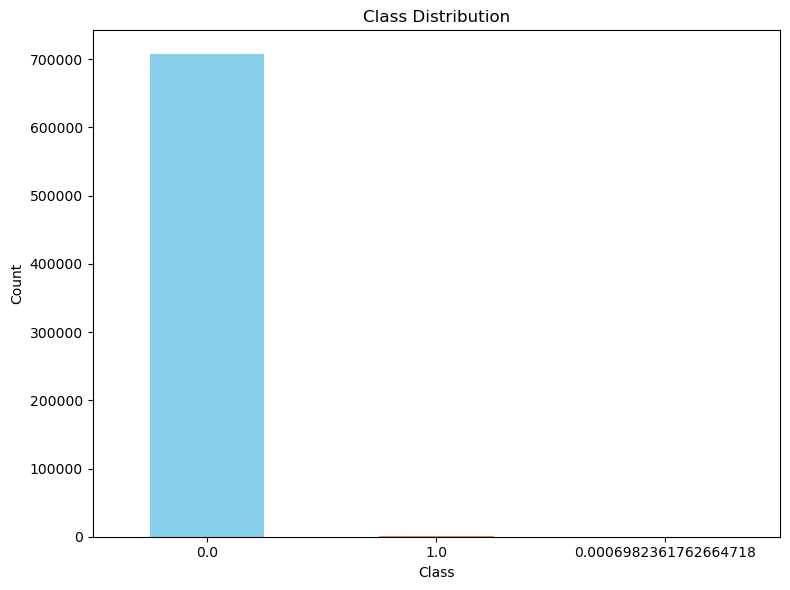

In [19]:
# If we have a target column, analyze the class distribution
if target_column:
    class_dist = pandas_df[target_column].value_counts()
    print(f"\nClass Distribution:\n{class_dist}")
    
    # Visualize class distribution
    plt.figure(figsize=(8, 6))
    class_dist.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig('/tmp/class_distribution.png')
    
    # Calculate class imbalance
    if len(class_dist) == 2:
        imbalance_ratio = class_dist.values[0] / class_dist.values[1]
        print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}:1")


In [20]:
# Statistical summary
numeric_summary = pandas_df.describe()
print("\nNumerical Summary Statistics:")
print(numeric_summary)

StatementMeta(team14elliptic, 25, 21, Finished, Available, Finished)


Numerical Summary Statistics:
            indegree      outdegree         in_btc        out_btc  \
count  707498.000000  707498.000000  707498.000000  707498.000000   
mean        1.489286       1.698080     109.726563     114.299036   
std         5.573256       3.981421    1933.459387    1928.817792   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.080000       1.150250   
50%         1.000000       2.000000       8.250000      24.260000   
75%         1.000000       2.000000      48.610000      50.000000   
max       965.000000     327.000000  432110.107452  432109.887452   

           total_btc    mean_in_btc   mean_out_btc   in_malicious  \
count  707498.000000  707498.000000  707498.000000  707498.000000   
mean      224.025841      92.420072      74.597710       0.000694   
std      3815.212506    1643.631397    1288.399317       0.026335   
min         0.002762       0.000000       0.000000       0.000000   
25

StatementMeta(team14elliptic, 25, 22, Finished, Available, Finished)

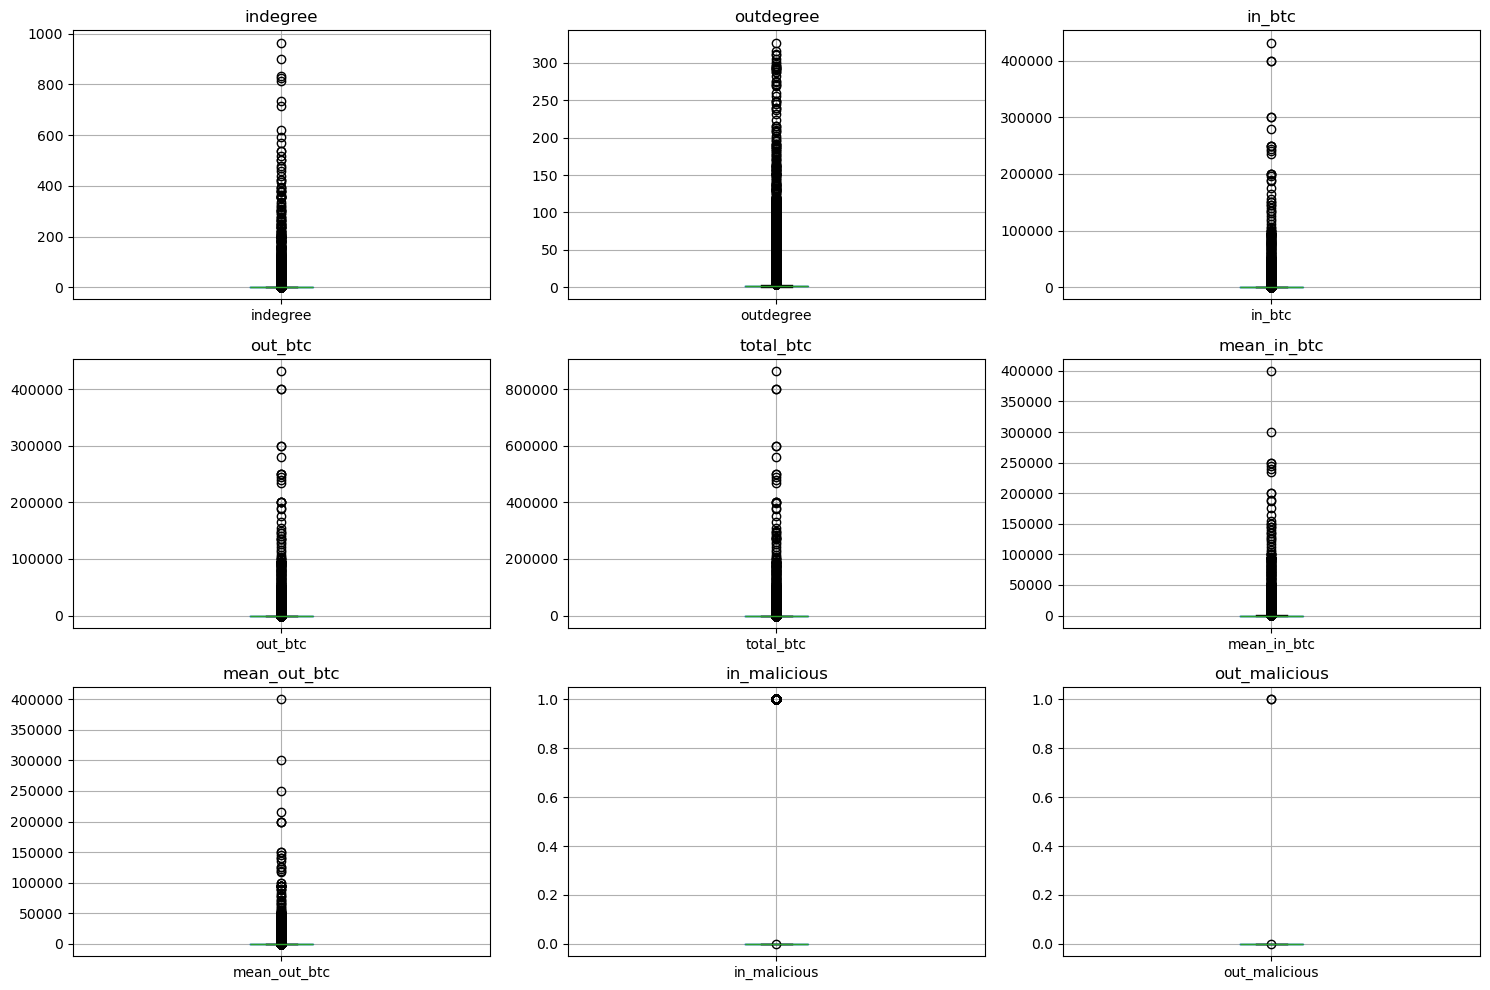

In [21]:
# Check for outliers in numeric columns using box plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:min(9, len(numeric_cols))]):  # Limit to 9 plots
    if i >= 9:
        break
    plt.subplot(3, 3, i+1)
    pandas_df.boxplot(column=col)
    plt.title(col)
    plt.tight_layout()
plt.savefig('/tmp/boxplots.png')

StatementMeta(team14elliptic, 25, 23, Finished, Available, Finished)

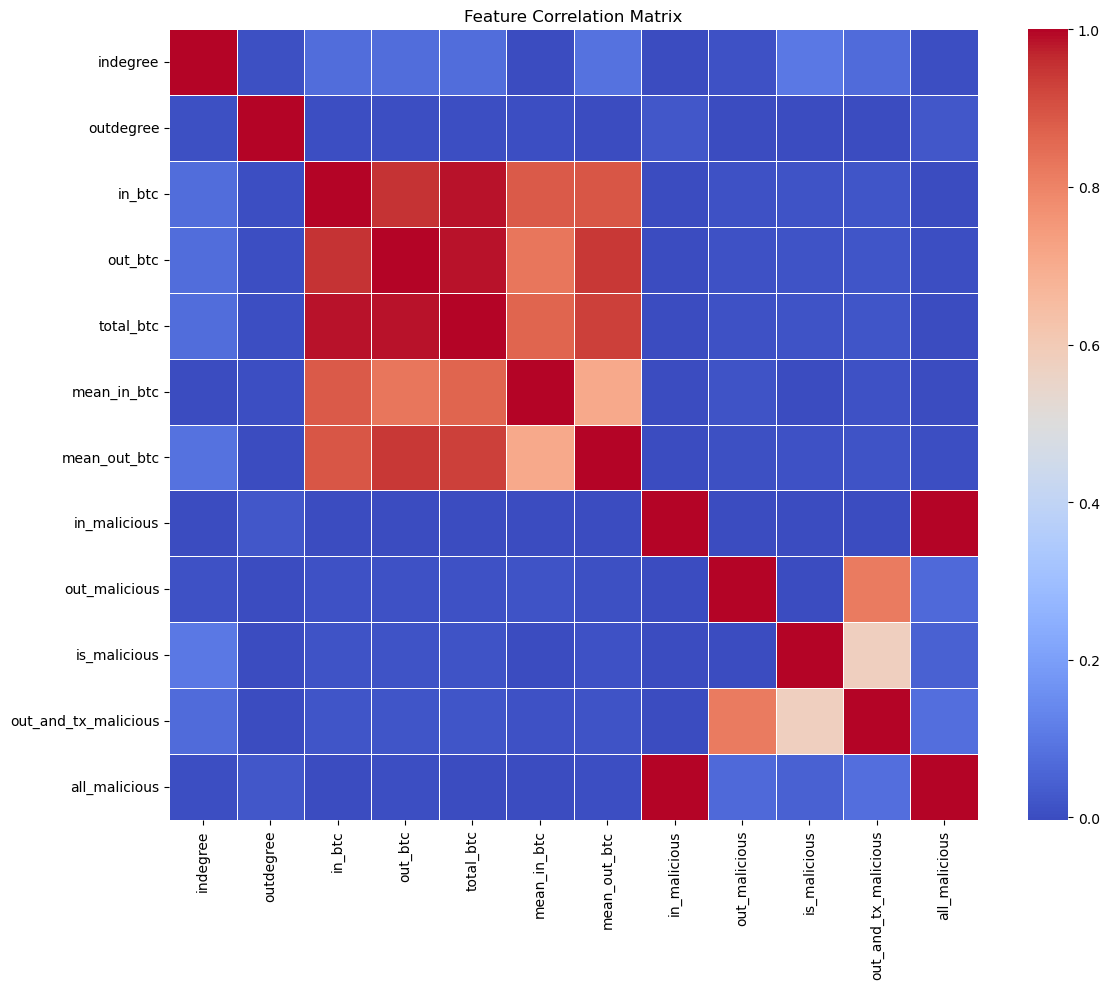

In [22]:
# Correlation matrix
if len(numeric_cols) > 1:
    correlation_matrix = pandas_df[numeric_cols].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('/tmp/correlation_matrix.png')

In [23]:
# Save EDA results
numeric_summary.to_csv('/tmp/summary_statistics.csv')
correlation_matrix.to_csv('/tmp/correlation_matrix.csv')

StatementMeta(team14elliptic, 25, 24, Finished, Available, Finished)

In [24]:
# Upload EDA results to Azure using our helper function
summary_spark_df = spark.createDataFrame(numeric_summary.reset_index())
corr_spark_df = spark.createDataFrame(correlation_matrix.reset_index())

save_to_gold(summary_spark_df, "bitcoin_summary_statistics")
save_to_gold(corr_spark_df, "bitcoin_correlation_matrix")

StatementMeta(team14elliptic, 25, 25, Finished, Available, Finished)

Error saving bitcoin_summary_statistics: An error occurred while calling o4679.parquet.
: org.apache.hadoop.fs.azure.AzureException: com.microsoft.azure.storage.StorageException: This operation is not permitted on a non-empty directory.
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2720)
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2730)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteFile(NativeAzureFileSystem.java:2670)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem$2.execute(NativeAzureFileSystem.java:2421)
	at org.apache.hadoop.fs.azure.AzureFileSystemThreadPoolExecutor.executeParallel(AzureFileSystemThreadPoolExecutor.java:223)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteWithoutAuth(NativeAzureFileSystem.java:2433)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.delete(NativeAzureFileSystem.java:2483)
	at org.apache.hadoop.fs.azure.NativeAzure

In [25]:
# Function to create a transaction graph from the data
def create_transaction_graph(df):
    # Try to identify source and target columns
    potential_src_cols = ['source', 'src', 'from', 'sender', 'input', 'tx_hash_input']
    potential_dst_cols = ['target', 'dst', 'to', 'receiver', 'output', 'tx_hash_output']
    
    src_col = None
    dst_col = None
    
    for col in potential_src_cols:
        if col in df.columns:
            src_col = col
            break
    
    for col in potential_dst_cols:
        if col in df.columns:
            dst_col = col
            break
    
    if not src_col or not dst_col:
        print("Source or target columns not found. Looking for columns with transaction IDs...")
        # Try to find columns that might contain transaction IDs
        for col in df.columns:
            if 'tx' in col.lower() or 'hash' in col.lower() or 'id' in col.lower():
                print(f"Potential transaction ID column: {col}")
        
        # Default to first two columns if we can't find specific source/target
        print("Using first two columns as source and target (fallback)")
        src_col = df.columns[0]
        dst_col = df.columns[1]
    
    print(f"Using {src_col} as source column and {dst_col} as target column")
    
    # Create edges with weights (if available)
    if 'weight' in df.columns:
        edges = list(zip(df[src_col], df[dst_col], df['weight']))
        G = nx.DiGraph()
        for u, v, w in edges:
            G.add_edge(u, v, weight=w)
    else:
        edges = list(zip(df[src_col], df[dst_col]))
        G = nx.DiGraph()
        G.add_edges_from(edges)
    
    return G, src_col, dst_col

StatementMeta(team14elliptic, 25, 26, Finished, Available, Finished)

StatementMeta(team14elliptic, 25, 27, Finished, Available, Finished)

Source or target columns not found. Looking for columns with transaction IDs...
Potential transaction ID column: tx_hash
Potential transaction ID column: out_and_tx_malicious
Using first two columns as source and target (fallback)
Using tx_hash as source column and indegree as target column

Graph Statistics:
Number of nodes: 707723
Number of edges: 707498
Is directed: True
Is connected: False
Number of weakly connected components: 225


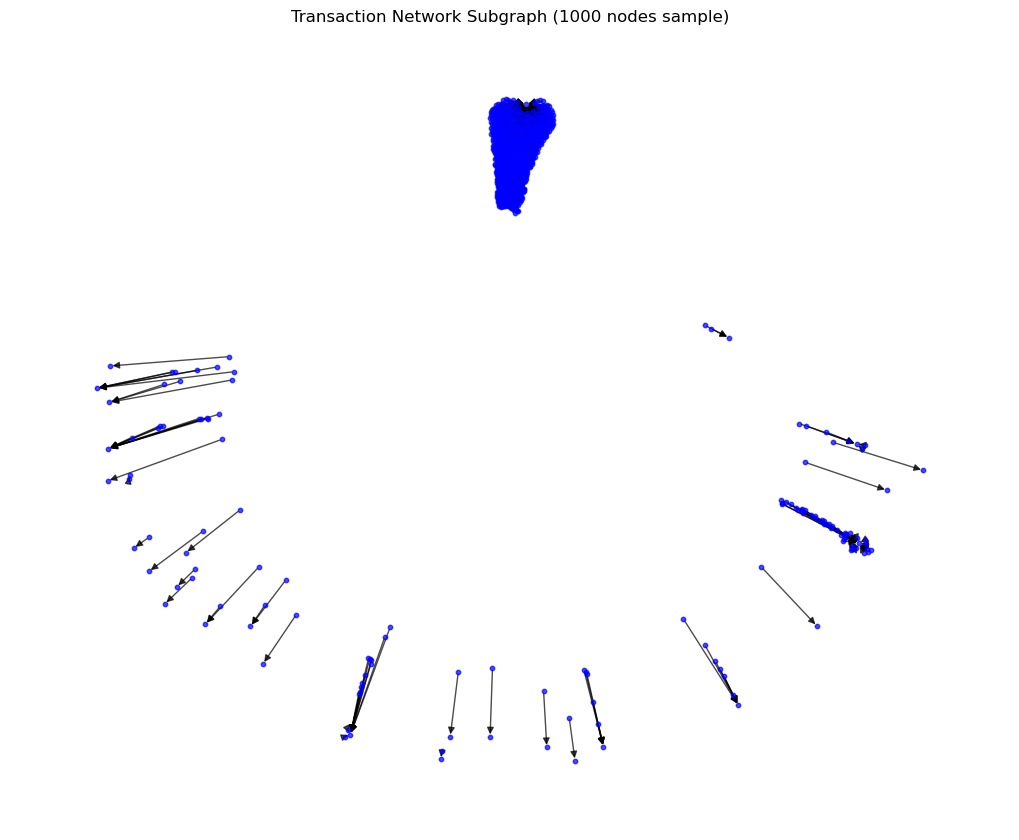

In [26]:
# Create the transaction graph
try:
    G, src_col, dst_col = create_transaction_graph(pandas_df)
    
    # Basic graph statistics
    print("\nGraph Statistics:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Is directed: {nx.is_directed(G)}")
    print(f"Is connected: {nx.is_weakly_connected(G)}")
    print(f"Number of weakly connected components: {nx.number_weakly_connected_components(G)}")
    
    # Network visualization (for small subgraphs)
    if G.number_of_nodes() <= 1000:
        # Visualize the whole graph
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, node_size=10, node_color='blue', alpha=0.7, with_labels=False, arrows=True)
        plt.title('Transaction Network Graph')
        plt.savefig('/tmp/transaction_graph.png')
    else:
        # Sample a subgraph for visualization
        subgraph_nodes = list(G.nodes())[:1000]
        subgraph = G.subgraph(subgraph_nodes)
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(subgraph, seed=42)
        nx.draw(subgraph, pos, node_size=10, node_color='blue', alpha=0.7, with_labels=False, arrows=True)
        plt.title('Transaction Network Subgraph (1000 nodes sample)')
        plt.savefig('/tmp/transaction_subgraph.png')
    
    # Extract node-level features from graph
    node_centrality = {}
    
    # Calculate degree centrality
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())
    
    # Calculate PageRank
    pagerank = nx.pagerank(G, alpha=0.85)
    
    # Calculate betweenness centrality (for a sample if the graph is too large)
    if G.number_of_nodes() > 1000:
        # Sample nodes for betweenness calculation
        sampled_nodes = list(G.nodes())[:1000]
        sampled_subgraph = G.subgraph(sampled_nodes)
        betweenness = nx.betweenness_centrality(sampled_subgraph)
    else:
        betweenness = nx.betweenness_centrality(G)
    
    # Combine centrality measures
    for node in G.nodes():
        node_centrality[node] = {
            'in_degree': in_degree.get(node, 0),
            'out_degree': out_degree.get(node, 0),
            'pagerank': pagerank.get(node, 0),
            'betweenness': betweenness.get(node, 0) if node in betweenness else 0
        }
    
    # Add graph-based features to the dataframe
    graph_features = []
    for i, row in pandas_df.iterrows():
        source = row[src_col]
        target = row[dst_col]
        
        source_features = node_centrality.get(source, 
                                              {'in_degree': 0, 'out_degree': 0, 
                                               'pagerank': 0, 'betweenness': 0})
        target_features = node_centrality.get(target, 
                                              {'in_degree': 0, 'out_degree': 0, 
                                               'pagerank': 0, 'betweenness': 0})
        
        graph_features.append({
            'source_in_degree': source_features['in_degree'],
            'source_out_degree': source_features['out_degree'],
            'source_pagerank': source_features['pagerank'],
            'source_betweenness': source_features['betweenness'],
            'target_in_degree': target_features['in_degree'],
            'target_out_degree': target_features['out_degree'],
            'target_pagerank': target_features['pagerank'],
            'target_betweenness': target_features['betweenness']
        })
    
    # Convert to DataFrame and add to pandas_df
    graph_features_df = pd.DataFrame(graph_features)
    for col in graph_features_df.columns:
        pandas_df[col] = graph_features_df[col]
    
    # Update numeric columns
    numeric_cols.extend(graph_features_df.columns)
except Exception as e:
    print(f"Error in graph creation and analysis: {str(e)}")
    print("Continuing without graph-based features...")

In [27]:
# Try to implement Node2Vec embeddings if available
try:
    from node2vec import Node2Vec
    
    # Generate Node2Vec embeddings
    print("\nGenerating Node2Vec embeddings...")
    node2vec = Node2Vec(G, dimensions=32, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1)
    
    # Function to get embedding for a node
    def get_node_embedding(node):
        try:
            return model.wv[str(node)]
        except KeyError:
            return np.zeros(32)  # Return zeros if node not in embeddings
    
    # Add embeddings to pandas_df
    node_embeddings = {}
    for node in G.nodes():
        node_embeddings[node] = get_node_embedding(node)
    
    # Add embeddings as features
    for i, row in pandas_df.iterrows():
        source = row[src_col]
        target = row[dst_col]
        
        source_emb = node_embeddings.get(source, np.zeros(32))
        target_emb = node_embeddings.get(target, np.zeros(32))
        
        # Average the embeddings
        avg_emb = (source_emb + target_emb) / 2
        
        # Add first 8 dimensions as features
        for j in range(8):
            pandas_df.loc[i, f'node2vec_emb_{j}'] = avg_emb[j]
        
        # Add a few more derived features
        pandas_df.loc[i, 'node2vec_emb_norm'] = np.linalg.norm(avg_emb)
        pandas_df.loc[i, 'node2vec_src_tgt_similarity'] = np.dot(source_emb, target_emb) / (np.linalg.norm(source_emb) * np.linalg.norm(target_emb)) if np.linalg.norm(source_emb) * np.linalg.norm(target_emb) > 0 else 0
    
    # Update numeric columns with embedding features
    node2vec_cols = [col for col in pandas_df.columns if 'node2vec' in col]
    numeric_cols.extend(node2vec_cols)
    
    # Visualize embeddings with t-SNE
    print("Creating t-SNE visualization of Node2Vec embeddings...")
    
    # Collect embeddings for visualization
    nodes = list(node_embeddings.keys())
    embeddings = np.array([node_embeddings[node] for node in nodes])
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Create a DataFrame for the visualization
    embedding_df = pd.DataFrame({
        'node': nodes,
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1]
    })
    
    # If we have a target column, add labels for visualization
    if target_column:
        # Create a mapping from node to label
        node_labels = {}
        for i, row in pandas_df.iterrows():
            source = row[src_col]
            target = row[dst_col]
            label = row[target_column]
            
            # Assign label to both source and target
            node_labels[source] = label
            node_labels[target] = label
        
        # Add labels to embedding_df
        embedding_df['label'] = embedding_df['node'].map(node_labels).fillna(-1)
        
        # Visualize
        plt.figure(figsize=(10, 8))
        for label in embedding_df['label'].unique():
            mask = embedding_df['label'] == label
            plt.scatter(
                embedding_df.loc[mask, 'x'],
                embedding_df.loc[mask, 'y'],
                label=f"Class {label}",
                alpha=0.7
            )
        plt.title('Node2Vec Embeddings (t-SNE visualization)')
        plt.xlabel('t-SNE component 1')
        plt.ylabel('t-SNE component 2')
        plt.legend()
        plt.savefig('/tmp/node2vec_embeddings.png')
    else:
        # Visualize without labels
        plt.figure(figsize=(10, 8))
        plt.scatter(embedding_df['x'], embedding_df['y'], alpha=0.7)
        plt.title('Node2Vec Embeddings (t-SNE visualization)')
        plt.xlabel('t-SNE component 1')
        plt.ylabel('t-SNE component 2')
        plt.savefig('/tmp/node2vec_embeddings.png')
        
    # Save embeddings to Gold container
    embedding_spark_df = spark.createDataFrame(embedding_df)
    save_to_gold(embedding_spark_df, "bitcoin_node_embeddings")
    
except ImportError:
    print("node2vec library not available. Skipping Node2Vec embeddings.")
except Exception as e:
    print(f"Error in Node2Vec embeddings generation: {str(e)}")
    print("Continuing without Node2Vec embeddings...")

StatementMeta(team14elliptic, 25, 28, Finished, Available, Finished)

node2vec library not available. Skipping Node2Vec embeddings.


StatementMeta(team14elliptic, 25, 29, Finished, Available, Finished)


Implementing autoencoder for anomaly detection...
Epoch 1/50, Loss: 0.271049
Epoch 6/50, Loss: 0.186144
Epoch 11/50, Loss: 0.181015
Epoch 16/50, Loss: 0.117600
Epoch 21/50, Loss: 0.113193
Epoch 26/50, Loss: 0.091389
Epoch 31/50, Loss: 0.088380
Epoch 36/50, Loss: 0.084479
Epoch 41/50, Loss: 0.091557
Epoch 46/50, Loss: 0.076188

Anomaly threshold (95th percentile): 0.000599
Number of anomalies detected: 35375
Percentage of anomalies: 5.00%

Anomaly Detection vs Actual Labels:
Predicted Anomaly   False  True 
Actual                          
0.000000           672122  34881
0.000698                1      0
1.000000                0    494
Error saving bitcoin_anomaly_detection: An error occurred while calling o4705.parquet.
: org.apache.hadoop.fs.azure.AzureException: com.microsoft.azure.storage.StorageException: This operation is not permitted on a non-empty directory.
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2720)
	at org.apache.h

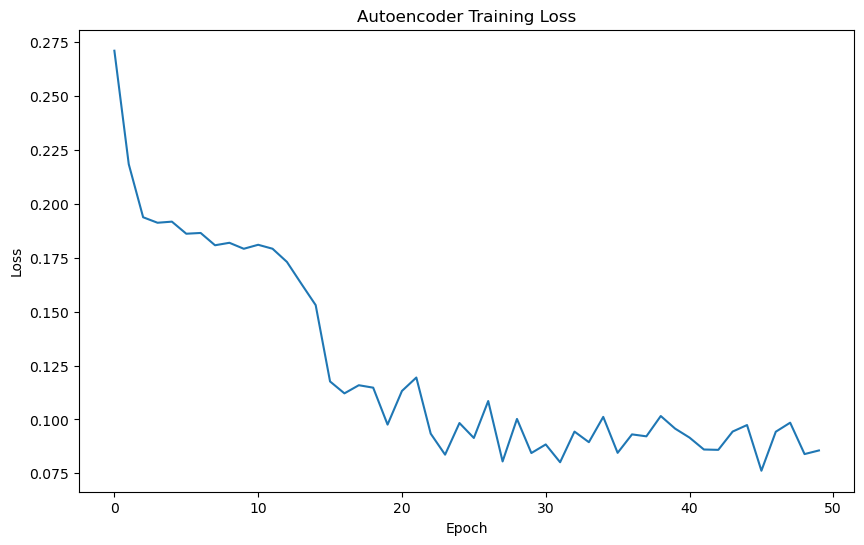

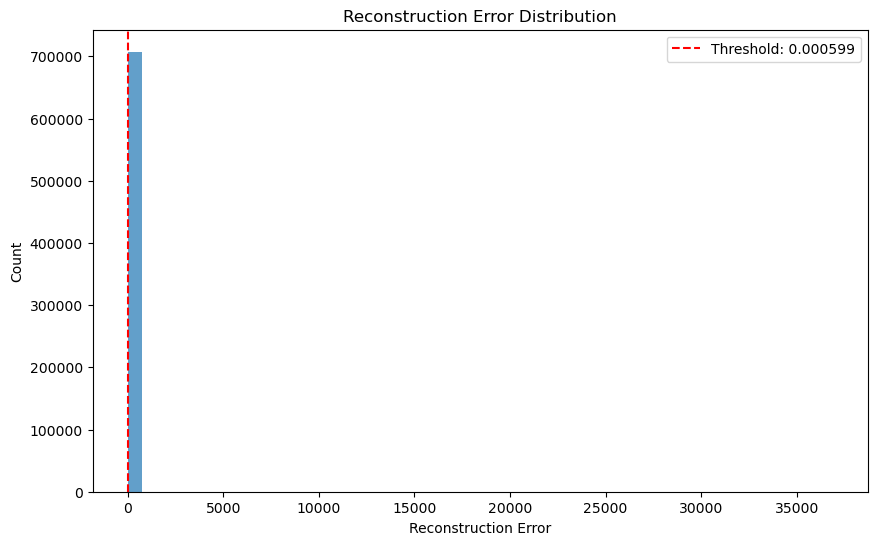

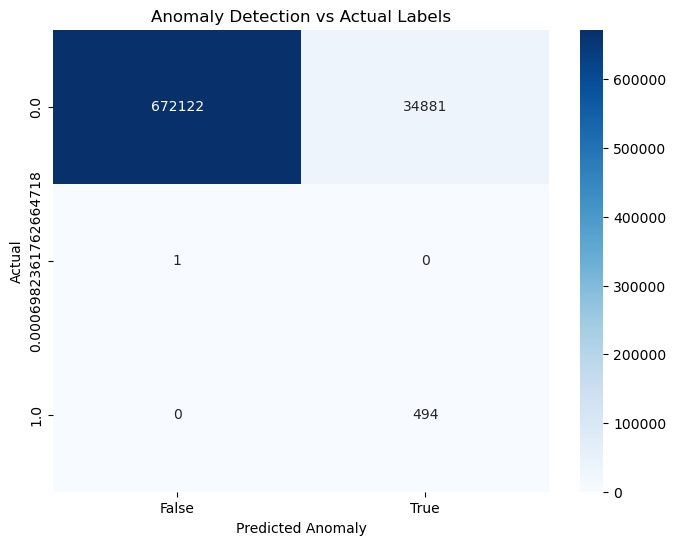

In [28]:
# Implementing an autoencoder for anomaly detection
print("\nImplementing autoencoder for anomaly detection...")
try:
    # Select only numeric features for the autoencoder
    numeric_df = pandas_df[numeric_cols].copy()
    
    # Standardize the data
    scaler = SklearnStandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)
    
    # Check if PyTorch is available
    try:
        import torch
        import torch.nn as nn
        HAS_TORCH = True
    except ImportError:
        HAS_TORCH = False
    
    # Define autoencoder with PyTorch if available
    if HAS_TORCH:
        class Autoencoder(nn.Module):
            def __init__(self, input_dim):
                super(Autoencoder, self).__init__()
                # Encoder
                self.encoder = nn.Sequential(
                    nn.Linear(input_dim, int(input_dim * 0.75)),
                    nn.ReLU(),
                    nn.Linear(int(input_dim * 0.75), int(input_dim * 0.5)),
                    nn.ReLU(),
                    nn.Linear(int(input_dim * 0.5), int(input_dim * 0.33)),
                    nn.ReLU(),
                    nn.Linear(int(input_dim * 0.33), int(input_dim * 0.25)),
                    nn.ReLU()
                )
                
                # Decoder
                self.decoder = nn.Sequential(
                    nn.Linear(int(input_dim * 0.25), int(input_dim * 0.33)),
                    nn.ReLU(),
                    nn.Linear(int(input_dim * 0.33), int(input_dim * 0.5)),
                    nn.ReLU(),
                    nn.Linear(int(input_dim * 0.5), int(input_dim * 0.75)),
                    nn.ReLU(),
                    nn.Linear(int(input_dim * 0.75), input_dim)
                )
            
            def forward(self, x):
                x = self.encoder(x)
                x = self.decoder(x)
                return x
        
        # Convert to PyTorch tensor
        tensor_x = torch.tensor(scaled_data, dtype=torch.float32)
        
        # Create dataloader
        from torch.utils.data import TensorDataset, DataLoader
        dataset = TensorDataset(tensor_x)
        dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
        
        # Initialize model
        input_dim = scaled_data.shape[1]
        model = Autoencoder(input_dim)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Training loop
        epochs = 50
        train_loss = []
        
        for epoch in range(epochs):
            running_loss = 0.0
            for data in dataloader:
                inputs = data[0]
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
            
            epoch_loss = running_loss / len(dataloader.dataset)
            train_loss.append(epoch_loss)
            if epoch % 5 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}')
        
        # Plot training loss
        plt.figure(figsize=(10, 6))
        plt.plot(train_loss)
        plt.title('Autoencoder Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('/tmp/autoencoder_loss.png')
        
        # Calculate reconstruction error
        model.eval()
        with torch.no_grad():
            reconstructions = model(tensor_x).numpy()
        
        mse = np.mean(np.power(scaled_data - reconstructions, 2), axis=1)
    else:
        # Alternative implementation using sklearn MLP
        from sklearn.neural_network import MLPRegressor
        
        # Create and train autoencoder
        input_dim = scaled_data.shape[1]
        hidden_layer_sizes = (
            int(input_dim * 0.75), 
            int(input_dim * 0.5), 
            int(input_dim * 0.33), 
            int(input_dim * 0.25), 
            int(input_dim * 0.33), 
            int(input_dim * 0.5), 
            int(input_dim * 0.75)
        )
        
        autoencoder = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            activation='relu',
            solver='adam',
            max_iter=200,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
        
        autoencoder.fit(scaled_data, scaled_data)
        
        # Calculate reconstruction error
        reconstructions = autoencoder.predict(scaled_data)
        mse = np.mean(np.power(scaled_data - reconstructions, 2), axis=1)
    
    # Calculate threshold (e.g., 95th percentile)
    threshold = np.percentile(mse, 95)
    print(f"\nAnomaly threshold (95th percentile): {threshold:.6f}")
    
    # Flag anomalies
    is_anomaly = mse > threshold
    print(f"Number of anomalies detected: {np.sum(is_anomaly)}")
    print(f"Percentage of anomalies: {100 * np.sum(is_anomaly) / len(mse):.2f}%")
    
    # Add anomaly scores to the original dataframe
    pandas_df['reconstruction_error'] = mse
    pandas_df['is_anomaly'] = is_anomaly
    
    # Visualize reconstruction error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(mse, bins=50, alpha=0.7)
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.6f}')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Count')
    plt.legend()
    plt.savefig('/tmp/reconstruction_error_dist.png')
    
    # Compare anomaly detection with actual labels (if available)
    if target_column:
        confusion_matrix = pd.crosstab(
            pandas_df[target_column], 
            pandas_df['is_anomaly'],
            rownames=['Actual'],
            colnames=['Predicted Anomaly']
        )
        print("\nAnomaly Detection vs Actual Labels:")
        print(confusion_matrix)
        
        # Visualize the comparison
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Anomaly Detection vs Actual Labels')
        plt.savefig('/tmp/anomaly_vs_actual.png')
    
    # Save the anomaly detection results
    anomaly_df = pd.DataFrame(pandas_df[['reconstruction_error', 'is_anomaly']])
    anomaly_spark_df = spark.createDataFrame(anomaly_df)
    save_to_gold(anomaly_spark_df, "bitcoin_anomaly_detection")
    
except Exception as e:
    print(f"Error in autoencoder implementation: {str(e)}")
    print("Continuing without autoencoder...")

In [33]:
# Prepare data for supervised learning
if target_column:
    print("\nPreparing data for supervised learning...")
    # Select features (use all numeric columns except target)
    feature_cols = [col for col in numeric_cols if col != target_column]
    X = pandas_df[feature_cols].values
    
    # Examine target column values
    unique_values = pandas_df[target_column].unique()
    print(f"Unique values in target column: {unique_values}")
    
    # Remap the target to binary classes
    print("Remapping target values to binary classes (0 for normal, 1 for anomalous)")
    y_original = pandas_df[target_column].values
    y = np.where(y_original == 0.0, 0, 1)
    
    # Check the new distribution
    unique_classes, class_counts = np.unique(y, return_counts=True)
    print(f"Remapped class distribution: {dict(zip(unique_classes, class_counts))}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = SklearnStandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Check for class imbalance in training set
    unique_train_classes, train_class_counts = np.unique(y_train, return_counts=True)
    print(f"Training set class distribution: {dict(zip(unique_train_classes, train_class_counts))}")
    
    # Calculate imbalance ratio
    if len(train_class_counts) > 1:
        imbalance_ratio = np.max(train_class_counts) / np.min(train_class_counts)
        print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")
    
    # Train XGBoost model
    print("\nTraining XGBoost model...")
    try:
        # Simple XGBoost model with scale_pos_weight
        xgb_model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            scale_pos_weight=imbalance_ratio,
            random_state=42
        )
        
        # Fit the model
        xgb_model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = xgb_model.predict(X_test_scaled)
        
        # Evaluate the model
        print("\nXGBoost Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Add basic predictions to pandas_df
        pandas_df['xgb_prediction'] = np.nan
        test_indices = np.arange(len(pandas_df))[-len(y_test):]
        
        for i, idx in enumerate(test_indices):
            if i < len(y_pred) and idx < len(pandas_df):
                pandas_df.iloc[idx, pandas_df.columns.get_loc('xgb_prediction')] = float(y_pred[i])
    
    except Exception as e:
        print(f"Error in XGBoost model training: {str(e)}")
        print("Continuing without XGBoost model...")
    
    # Simple RandomForest without Spark ML
    print("\nTraining scikit-learn RandomForest model...")
    try:
        from sklearn.ensemble import RandomForestClassifier as SklearnRF
        
        # Train RandomForest with class weights
        class_weight = {0: 1, 1: imbalance_ratio} if imbalance_ratio > 10 else None
        
        rf_model = SklearnRF(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            class_weight=class_weight
        )
        
        rf_model.fit(X_train_scaled, y_train)
        
        # Make predictions
        rf_pred = rf_model.predict(X_test_scaled)
        
        # Evaluate the model
        print("\nRandomForest Classification Report:")
        print(classification_report(y_test, rf_pred))
        
        # Add RF predictions to pandas_df
        pandas_df['rf_prediction'] = np.nan
        
        for i, idx in enumerate(test_indices):
            if i < len(rf_pred) and idx < len(pandas_df):
                pandas_df.iloc[idx, pandas_df.columns.get_loc('rf_prediction')] = float(rf_pred[i])
        
        # Create simple ensemble predictions (majority vote)
        if 'xgb_prediction' in pandas_df.columns:
            pandas_df['ensemble_prediction'] = np.nan
            
            for i, idx in enumerate(test_indices):
                if i < len(rf_pred) and i < len(y_pred) and idx < len(pandas_df):
                    # Simple averaging
                    ensemble_pred = (float(rf_pred[i]) + float(y_pred[i])) / 2.0
                    ensemble_class = 1 if ensemble_pred >= 0.5 else 0
                    pandas_df.iloc[idx, pandas_df.columns.get_loc('ensemble_prediction')] = float(ensemble_class)
            
            # Evaluate ensemble
            ensemble_preds = pandas_df.iloc[test_indices]['ensemble_prediction'].dropna().values
            if len(ensemble_preds) > 0:
                print("\nEnsemble Model Classification Report:")
                print(classification_report(y_test[:len(ensemble_preds)], ensemble_preds))
        
    except Exception as e:
        print(f"Error in scikit-learn RandomForest model training: {str(e)}")
        print("Continuing without RandomForest model...")
else:
    print("\nNo target column identified for supervised learning.")
    print("Skipping supervised learning models.")

StatementMeta(team14elliptic, 25, 34, Finished, Available, Finished)


Preparing data for supervised learning...
Unique values in target column: [0.00000000e+00 1.00000000e+00 6.98236176e-04]
Remapping target values to binary classes (0 for normal, 1 for anomalous)
Remapped class distribution: {0: 707003, 1: 495}
Training set: 565998 samples
Test set: 141500 samples
Training set class distribution: {0: 565611, 1: 387}
Class imbalance ratio: 1461.53:1

Training XGBoost model...

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    141392
           1       1.00      0.98      0.99       108

    accuracy                           1.00    141500
   macro avg       1.00      0.99      1.00    141500
weighted avg       1.00      1.00      1.00    141500


Training scikit-learn RandomForest model...

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    141392
           1       1.00      0.98     

StatementMeta(team14elliptic, 25, 36, Finished, Available, Finished)


Performing community detection...
Number of communities detected: 225

Analyzing relationship between communities and illicit activities...
Error saving bitcoin_community_statistics: An error occurred while calling o5116.parquet.
: org.apache.hadoop.fs.azure.AzureException: com.microsoft.azure.storage.StorageException: This operation is not permitted on a non-empty directory.
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2720)
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2730)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteFile(NativeAzureFileSystem.java:2670)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem$2.execute(NativeAzureFileSystem.java:2421)
	at org.apache.hadoop.fs.azure.AzureFileSystemThreadPoolExecutor.executeParallel(AzureFileSystemThreadPoolExecutor.java:223)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteWithoutAuth(NativeAzureFileSystem.jav

/tmp/ipykernel_6922/1132148280.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', max_comm)


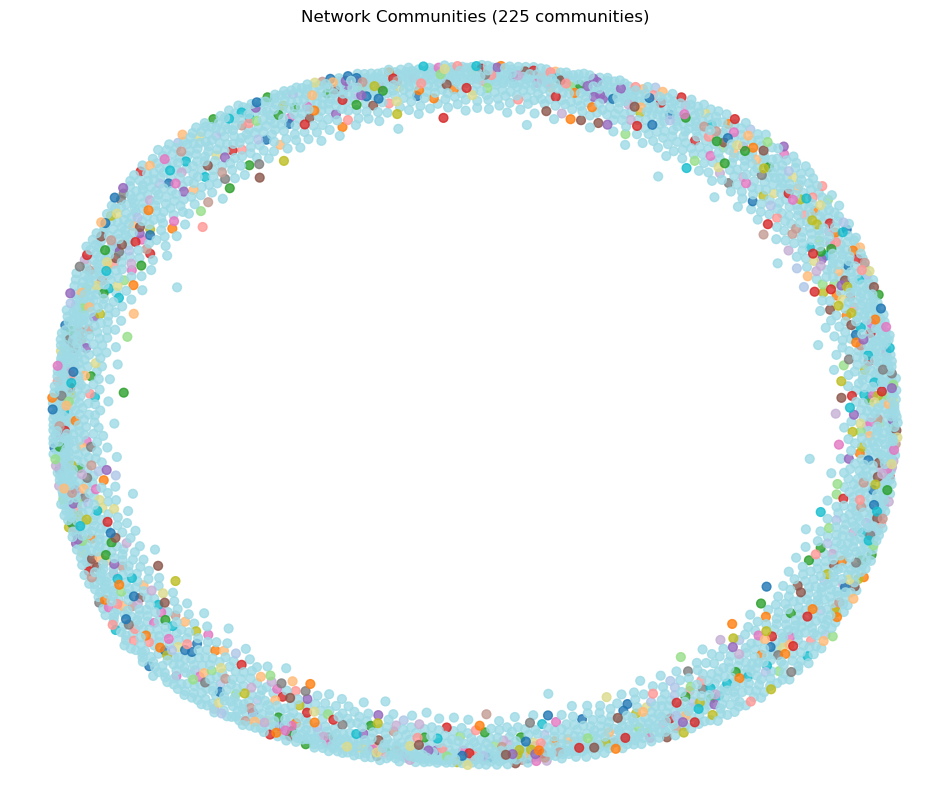

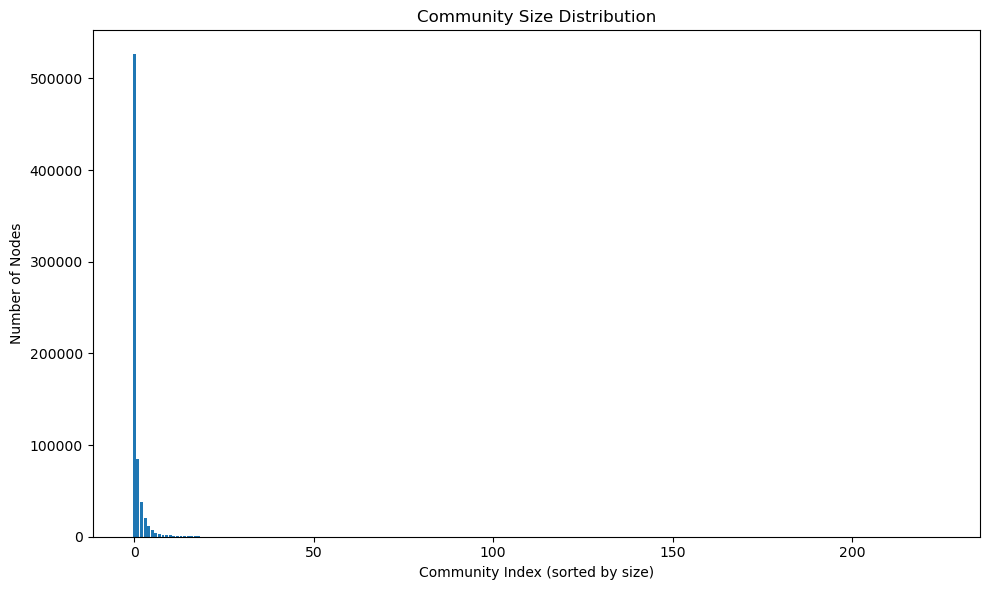

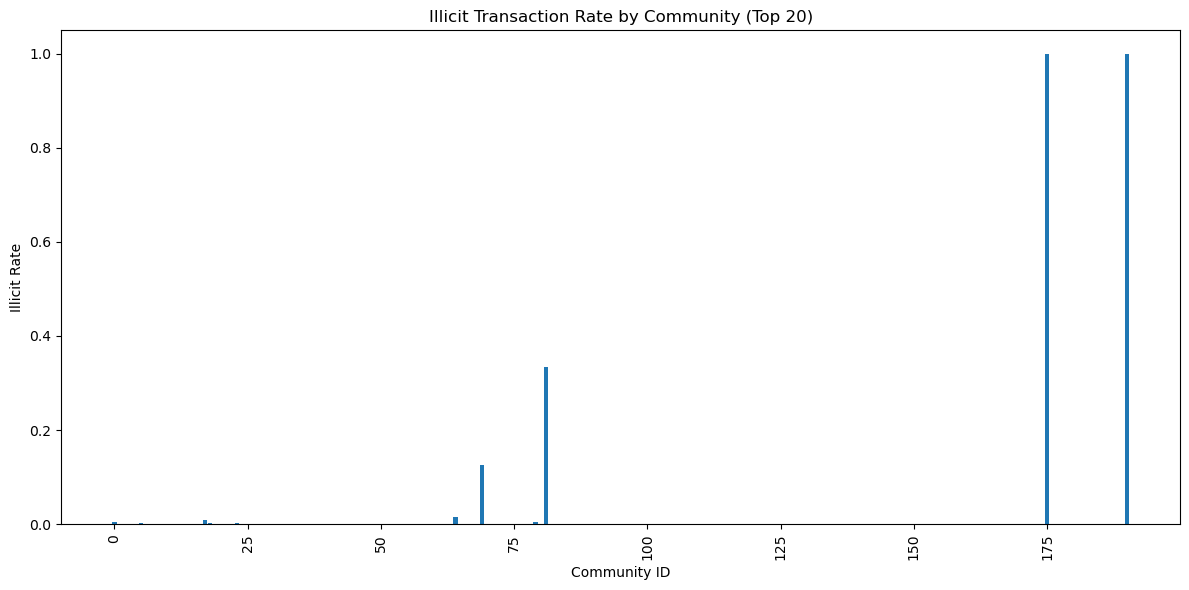

In [35]:
# Perform community detection and advanced network analysis
try:
    print("\nPerforming community detection...")
    # Convert directed graph to undirected for community detection
    G_undirected = G.to_undirected()
    
    # Detect communities using connected components as a fallback
    communities = {}
    for i, comp in enumerate(nx.connected_components(G_undirected)):
        for node in comp:
            communities[node] = i
    
    # Count communities
    num_communities = len(set(communities.values()))
    print(f"Number of communities detected: {num_communities}")
    
    # Visualize communities (sample if too large)
    if G_undirected.number_of_nodes() > 1000:
        # Sample nodes from each community
        sampled_nodes = []
        for comm_id in set(communities.values()):
            comm_nodes = [n for n, c in communities.items() if c == comm_id]
            # Sample up to 50 nodes from each community
            sample_size = min(50, len(comm_nodes))
            if sample_size > 0:  # Ensure we don't try to sample from empty lists
                sampled_nodes.extend(np.random.choice(comm_nodes, size=sample_size, replace=False))
        
        if sampled_nodes:  # Only create subgraph if we have sampled nodes
            subgraph = G_undirected.subgraph(sampled_nodes)
            subgraph_communities = {n: communities[n] for n in subgraph.nodes()}
            
            # Visualize
            plt.figure(figsize=(12, 10))
            pos = nx.spring_layout(subgraph, k=0.3, seed=42)
            
            # Color nodes by community (limit to 20 colors for visualization)
            max_comm = min(20, num_communities)
            cmap = plt.cm.get_cmap('tab20', max_comm)
            nx.draw_networkx_nodes(
                subgraph, pos, 
                node_size=40, 
                node_color=[cmap(min(subgraph_communities[n], max_comm-1)) for n in subgraph.nodes()],
                alpha=0.8
            )
            nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
            
            plt.title(f'Network Communities ({num_communities} communities)')
            plt.axis('off')
            plt.savefig('/tmp/network_communities.png')
    
    # Calculate community statistics
    community_sizes = {}
    for comm_id in set(communities.values()):
        community_sizes[comm_id] = len([n for n in communities if communities[n] == comm_id])
    
    # Plot community size distribution
    plt.figure(figsize=(10, 6))
    sizes = sorted(community_sizes.values(), reverse=True)
    plt.bar(range(len(sizes)), sizes)
    plt.title('Community Size Distribution')
    plt.xlabel('Community Index (sorted by size)')
    plt.ylabel('Number of Nodes')
    plt.tight_layout()
    plt.savefig('/tmp/community_size_distribution.png')
    
    # Add community information to pandas_df
    pandas_df['community_id'] = None
    for i, row in pandas_df.iterrows():
        source = row[src_col]
        target = row[dst_col]
        
        source_community = communities.get(source)
        target_community = communities.get(target)
        
        # Assign community based on source and target
        if source_community is not None and target_community is not None:
            # If source and target are in same community, use that
            if source_community == target_community:
                pandas_df.loc[i, 'community_id'] = source_community
            else:
                # Otherwise use source community
                pandas_df.loc[i, 'community_id'] = source_community
        elif source_community is not None:
            pandas_df.loc[i, 'community_id'] = source_community
        elif target_community is not None:
            pandas_df.loc[i, 'community_id'] = target_community
    
    # Check if communities are related to illicit activities (if target column exists)
    if target_column:
        print("\nAnalyzing relationship between communities and illicit activities...")
        # Group by community and calculate statistics
        community_stats = pandas_df.groupby('community_id').agg({
            target_column: ['mean', 'count', 'sum']
        }).reset_index()
        
        if not community_stats.empty:
            community_stats.columns = ['community_id', 'illicit_rate', 'total_count', 'illicit_count']
            community_stats['licit_count'] = community_stats['total_count'] - community_stats['illicit_count']
            
            # Sort by illicit rate
            community_stats = community_stats.sort_values('illicit_rate', ascending=False)
            
            # Visualize communities by illicit rate (top 20)
            plt.figure(figsize=(12, 6))
            top_n = min(20, len(community_stats))
            plt.bar(community_stats['community_id'].head(top_n), community_stats['illicit_rate'].head(top_n))
            plt.title('Illicit Transaction Rate by Community (Top 20)')
            plt.xlabel('Community ID')
            plt.ylabel('Illicit Rate')
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.savefig('/tmp/community_illicit_rate.png')
            
            # Save community statistics
            community_stats.to_csv('/tmp/community_statistics.csv', index=False)
            community_stats_spark = spark.createDataFrame(community_stats)
            save_to_gold(community_stats_spark, "bitcoin_community_statistics")
except Exception as e:
    print(f"Error in community detection: {str(e)}")
    print("Continuing without community analysis...")


StatementMeta(team14elliptic, 25, 38, Finished, Available, Finished)


Creating advanced feature relationship visualizations...
Error saving bitcoin_pca_results: An error occurred while calling o5134.parquet.
: org.apache.hadoop.fs.azure.AzureException: com.microsoft.azure.storage.StorageException: This operation is not permitted on a non-empty directory.
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2720)
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2730)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteFile(NativeAzureFileSystem.java:2670)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem$2.execute(NativeAzureFileSystem.java:2421)
	at org.apache.hadoop.fs.azure.AzureFileSystemThreadPoolExecutor.executeParallel(AzureFileSystemThreadPoolExecutor.java:223)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteWithoutAuth(NativeAzureFileSystem.java:2433)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.delete(NativeAzureFileSystem.ja

<Figure size 2000x1500 with 0 Axes>

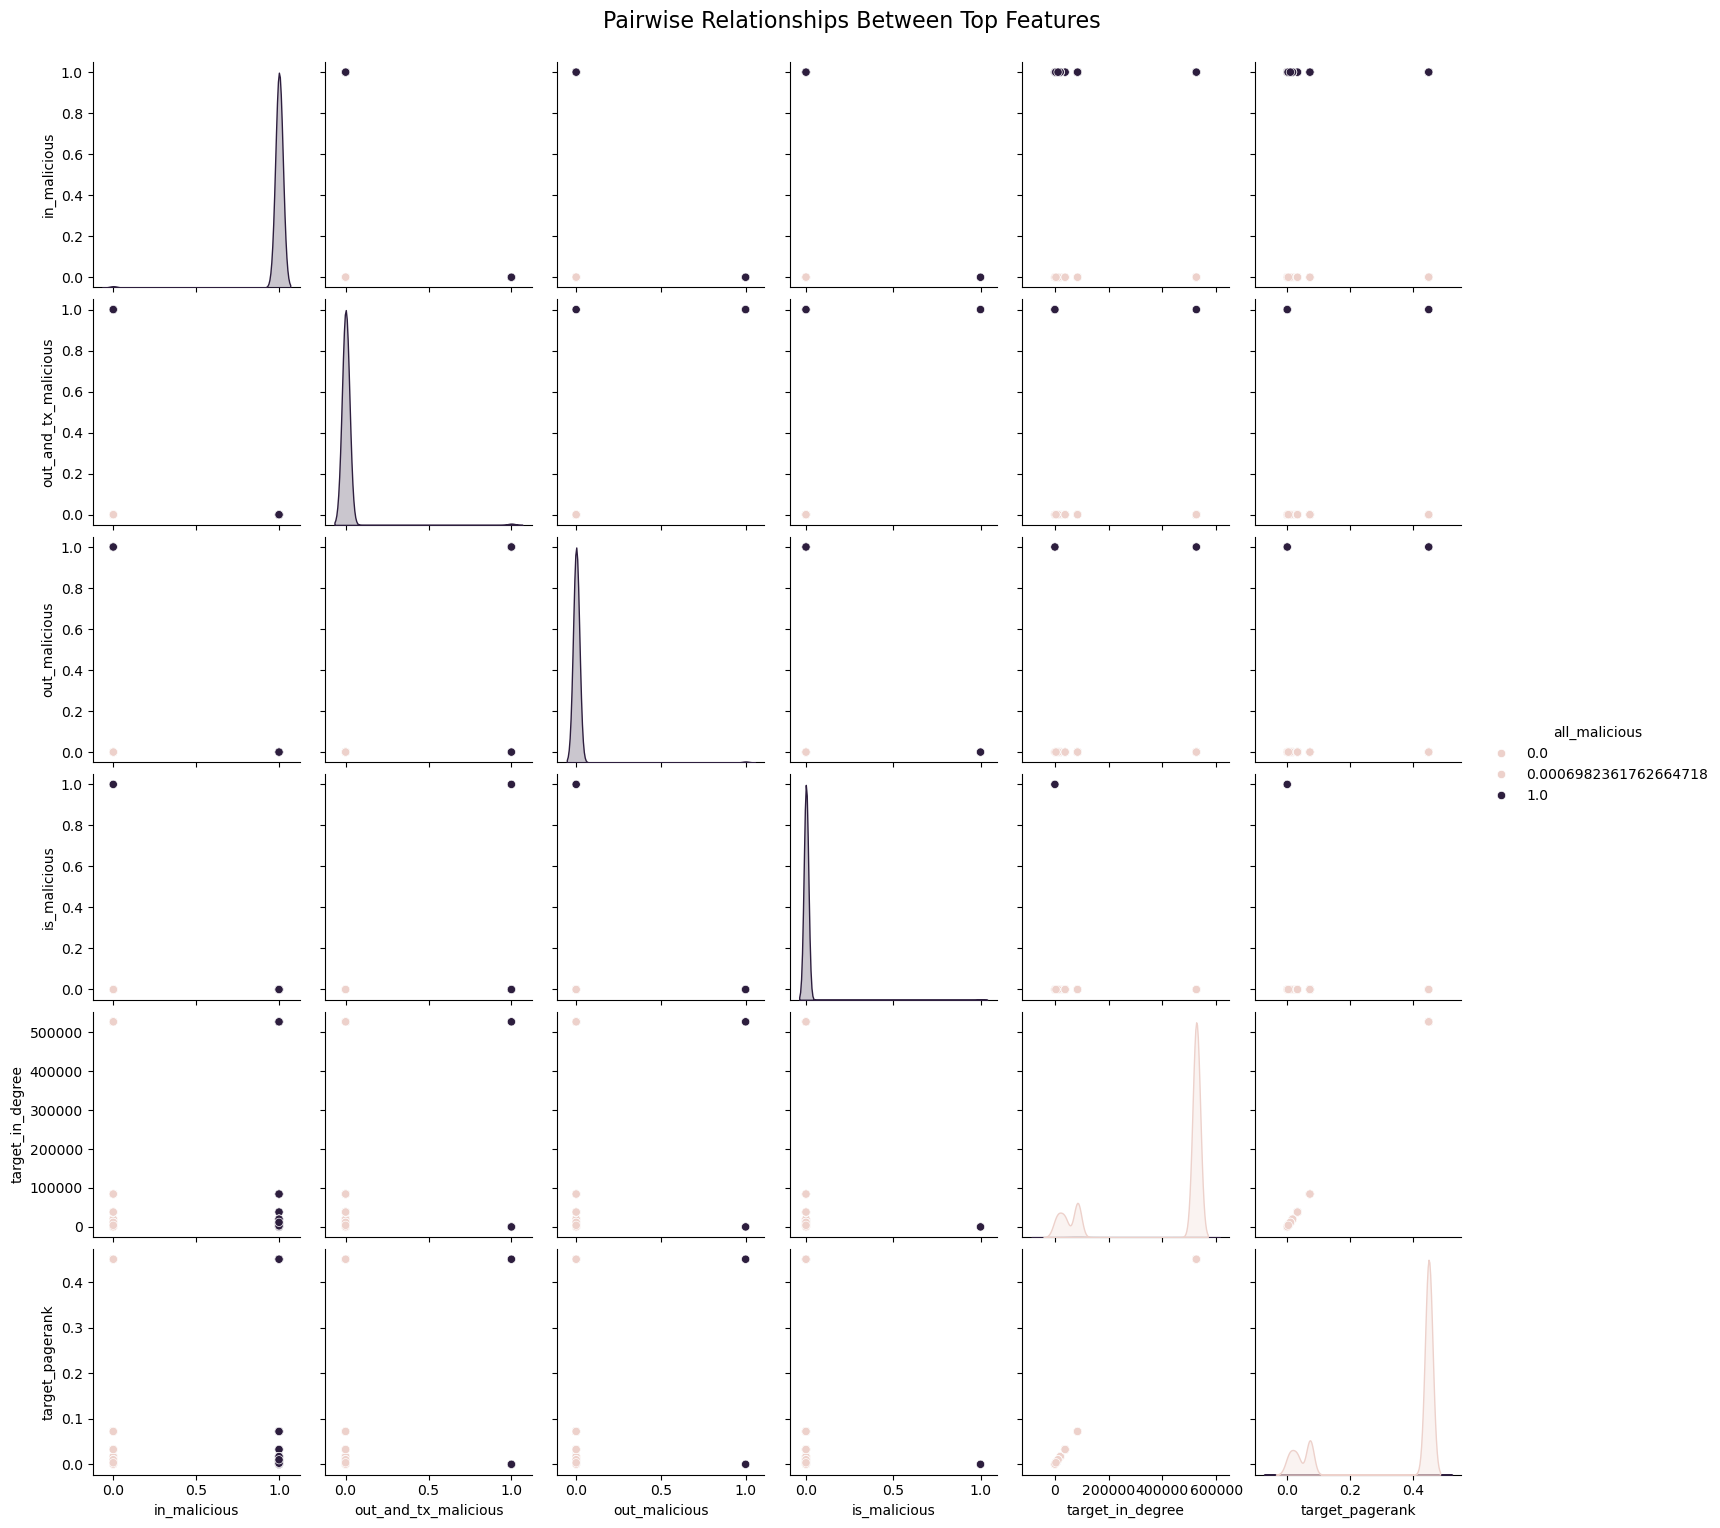

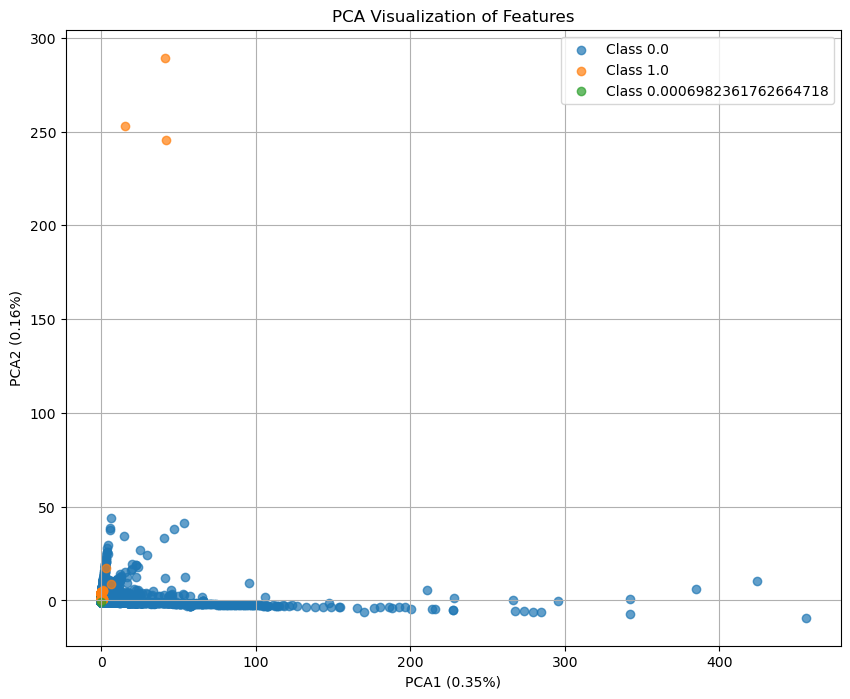

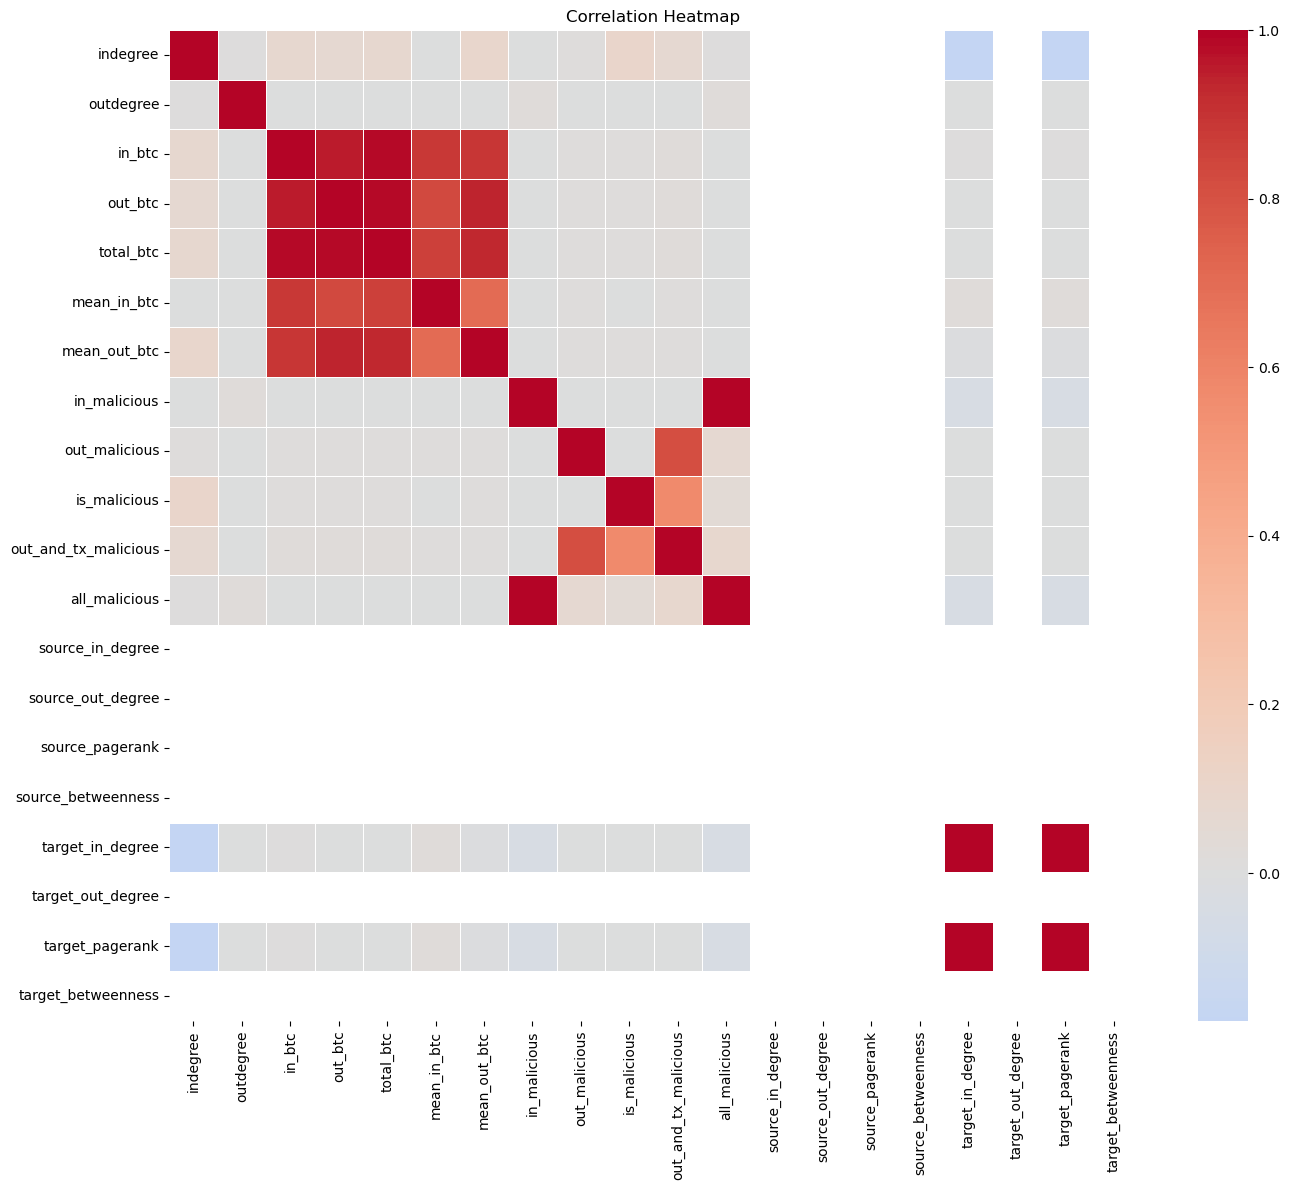

In [37]:
# Advanced feature relationship visualizations
if len(numeric_cols) > 1:
    print("\nCreating advanced feature relationship visualizations...")
    
    # Select top features based on correlation with target
    if target_column:
        try:
            # Calculate correlation with target
            feature_corrs = []
            for col in numeric_cols:
                if col != target_column and col in pandas_df.columns:
                    try:
                        corr = np.abs(pandas_df[col].corr(pandas_df[target_column]))
                        if not np.isnan(corr):
                            feature_corrs.append((col, corr))
                    except:
                        # Skip columns that cause issues
                        pass
            
            if feature_corrs:
                # Sort and select top features
                sorted_features = sorted(feature_corrs, key=lambda x: x[1], reverse=True)
                top_features = [col for col, _ in sorted_features[:min(6, len(sorted_features))]]
                
                # Create a pairplot for the top features
                pair_cols = top_features + [target_column]
                # Make sure all columns exist
                pair_cols = [col for col in pair_cols if col in pandas_df.columns]
                
                if len(pair_cols) > 1:  # Need at least 2 columns for pairplot
                    pair_df = pandas_df[pair_cols].copy()
                    plt.figure(figsize=(20, 15))
                    sns.pairplot(pair_df, hue=target_column)
                    plt.suptitle('Pairwise Relationships Between Top Features', y=1.02, fontsize=16)
                    plt.savefig('/tmp/feature_pairplot.png')
                
                # PCA visualization
                from sklearn.decomposition import PCA
                
                # Select features and standardize
                X_pca = pandas_df[numeric_cols].drop(columns=[target_column] if target_column in numeric_cols else [])
                # Replace any inf or NaN values
                X_pca = X_pca.replace([np.inf, -np.inf], np.nan).fillna(0)
                X_pca_scaled = SklearnStandardScaler().fit_transform(X_pca)
                
                # Apply PCA
                pca = PCA(n_components=2)
                pca_result = pca.fit_transform(X_pca_scaled)
                
                # Create DataFrame for visualization
                pca_df = pd.DataFrame({
                    'PCA1': pca_result[:, 0],
                    'PCA2': pca_result[:, 1],
                    'class': pandas_df[target_column].values
                })
                
                # Plot PCA results
                plt.figure(figsize=(10, 8))
                for label in pca_df['class'].unique():
                    mask = pca_df['class'] == label
                    plt.scatter(
                        pca_df.loc[mask, 'PCA1'],
                        pca_df.loc[mask, 'PCA2'],
                        label=f"Class {label}",
                        alpha=0.7
                    )
                plt.title('PCA Visualization of Features')
                plt.xlabel(f'PCA1 ({pca.explained_variance_ratio_[0]:.2f}%)')
                plt.ylabel(f'PCA2 ({pca.explained_variance_ratio_[1]:.2f}%)')
                plt.legend()
                plt.grid(True)
                plt.savefig('/tmp/pca_visualization.png')
                
                # Save PCA results
                pca_df.to_csv('/tmp/pca_results.csv', index=False)
                pca_df_spark = spark.createDataFrame(pca_df)
                save_to_gold(pca_df_spark, "bitcoin_pca_results")
        except Exception as e:
            print(f"Error in creating feature relationship visualizations: {str(e)}")
    
    # Create correlation heatmap with clustering
    try:
        # Replace inf values
        corr_data = pandas_df[numeric_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
        corr = corr_data.corr()
        
        plt.figure(figsize=(14, 12))
        sns.heatmap(corr, center=0, cmap='coolwarm', annot=False, linewidths=0.5)
        plt.title('Correlation Heatmap')
        plt.tight_layout()
        plt.savefig('/tmp/correlation_heatmap.png')
    except Exception as e:
        print(f"Error creating correlation heatmap: {str(e)}")

In [38]:
# Function to save images to Gold container
def save_image_to_gold(file_path, image_name):
    try:
        # Create a DataFrame with the image name and path
        image_df = pd.DataFrame({
            "image_name": [image_name],
            "image_path": [file_path]
        })
        
        # Save the image metadata to gold
        image_spark_df = spark.createDataFrame(image_df)
        save_to_gold(image_spark_df, f"visualization_metadata_{image_name}")
        print(f"Saved metadata for {image_name}")
    except Exception as e:
        print(f"Error saving metadata for {image_name}: {str(e)}")

# Save all images from /tmp
import os
image_files = [f for f in os.listdir('/tmp') if f.endswith('.png')]
for image_file in image_files:
    save_image_to_gold(f'/tmp/{image_file}', image_file)

# Create a comprehensive dataset for Power BI
print("\nCreating comprehensive dataset for Power BI...")
# Include all the features and model outputs in one dataset
powerbi_df = pandas_df.copy()

# Save to CSV for possible direct import into Power BI
powerbi_df.to_csv('/tmp/bitcoin_comprehensive_dataset.csv', index=False)

# Clean up dataframe - remove any columns that might cause issues
for col in powerbi_df.columns:
    if powerbi_df[col].dtype == 'object':
        # Convert object columns to string to avoid Spark schema issues
        powerbi_df[col] = powerbi_df[col].astype(str)
    
    # Replace inf values
    if col in numeric_cols:
        powerbi_df[col] = powerbi_df[col].replace([np.inf, -np.inf], np.nan)

# Fill NaN values
powerbi_df = powerbi_df.fillna({col: 0 for col in numeric_cols})
powerbi_df = powerbi_df.fillna("Unknown")

# Convert to Spark DataFrame and save
try:
    # Save in smaller chunks if necessary
    chunk_size = 10000
    if len(powerbi_df) > chunk_size:
        # Split into chunks
        for i in range(0, len(powerbi_df), chunk_size):
            chunk = powerbi_df.iloc[i:i+chunk_size]
            chunk_spark_df = spark.createDataFrame(chunk)
            save_to_gold(chunk_spark_df, f"bitcoin_comprehensive_dataset_chunk_{i//chunk_size}")
        print(f"Saved dataset in {(len(powerbi_df) // chunk_size) + 1} chunks")
    else:
        powerbi_spark_df = spark.createDataFrame(powerbi_df)
        save_to_gold(powerbi_spark_df, "bitcoin_comprehensive_dataset")
except Exception as e:
    print(f"Error saving comprehensive dataset: {str(e)}")
    print("Saving as CSV only")

# Create metadata file with column descriptions
metadata = []
for col in powerbi_df.columns:
    description = ""
    if col == target_column:
        description = "Target variable indicating illicit (1) or licit (0) transaction"
    elif col == 'reconstruction_error':
        description = "Reconstruction error from autoencoder (higher values indicate potential anomalies)"
    elif col == 'is_anomaly':
        description = "Flag indicating if transaction is detected as anomaly by autoencoder"
    elif col == 'community_id':
        description = "Community ID from network community detection"
    elif 'source_' in col:
        description = "Graph feature related to source node"
    elif 'target_' in col:
        description = "Graph feature related to target node"
    elif col in numeric_cols:
        description = "Numeric feature from dataset"
    elif col in categorical_cols:
        description = "Categorical feature from dataset"
    
    metadata.append({
        'column_name': col,
        'description': description
    })

metadata_df = pd.DataFrame(metadata)
metadata_df.to_csv('/tmp/bitcoin_dataset_metadata.csv', index=False)
metadata_spark_df = spark.createDataFrame(metadata_df)
save_to_gold(metadata_spark_df, "bitcoin_dataset_metadata")

# Print final summary
print("\n" + "="*80)
print("BITCOIN TRANSACTION ANOMALY DETECTION PROJECT SUMMARY")
print("="*80)

print("\nData Processing:")
print(f"- Processed {df.count()} transactions with {len(df.columns)} features")
print(f"- Cleaned dataset saved to: {cleaned_path}")

print("\nModels Implemented:")
models_implemented = []
models_implemented.append("1. Network analysis for graph-based features")
if 'node_embeddings' in locals():
    models_implemented.append("2. Node2Vec for node embeddings")
if 'mse' in locals():
    models_implemented.append("3. Autoencoder for unsupervised anomaly detection")
if target_column and 'xgb_model' in locals():
    models_implemented.append("4. XGBoost for supervised fraud detection")
if target_column and 'rf_model' in locals():
    models_implemented.append("5. RandomForest as a comparison model")
if target_column and 'xgb_model' in locals() and 'rf_model' in locals():
    models_implemented.append("6. Ensemble model combining XGBoost and RandomForest")

for model in models_implemented:
    print(model)

print("\nVisualizations Created:")
for image_file in image_files:
    print(f"- {image_file}")

print("\nPower BI Integration:")
print("- Comprehensive dataset created with all model predictions and features")
print("- Dataset metadata created for column descriptions")
print("- All files saved to Gold container for Power BI access")
print("\nAll files have been successfully saved to the Gold container.")
print("="*80)

StatementMeta(team14elliptic, 25, 39, Finished, Cancelled, Cancelled)

Error saving visualization_metadata_correlation_heatmap.png: An error occurred while calling o5152.parquet.
: org.apache.hadoop.fs.azure.AzureException: com.microsoft.azure.storage.StorageException: This operation is not permitted on a non-empty directory.
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2720)
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2730)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteFile(NativeAzureFileSystem.java:2670)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem$2.execute(NativeAzureFileSystem.java:2421)
	at org.apache.hadoop.fs.azure.AzureFileSystemThreadPoolExecutor.executeParallel(AzureFileSystemThreadPoolExecutor.java:223)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteWithoutAuth(NativeAzureFileSystem.java:2433)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.delete(NativeAzureFileSystem.java:2483)
	at org.apache.hadoop.